# Visualising Graph Embeddings
To provide us with some clues about how well they represent distances in the collection.

In [ ]:
# !pip uninstall -y umap-learn
!pip install umap-learn
!pip install datashader holoviews # for plotting

In [7]:
import numpy as np
import pandas as pd
from bokeh.plotting import show, output_notebook
import umap
import umap.plot
import os
from scipy.spatial import distance
from sklearn.neighbors import KDTree

pd.set_option('display.max_colwidth', None)

## 1. Import data

In [10]:
embeddings_folder = "./dglke_results/RotatE_heritageconnector_10" # best model according to dglke_logs/performance_logs.txt
mappings_folder = "../data/interim/train_test_split/"

entities = np.load(os.path.join(embeddings_folder, "heritageconnector_RotatE_entity.npy"))
relations = np.load(os.path.join(embeddings_folder, "heritageconnector_RotatE_relation.npy"))

entlabels = pd.read_csv(os.path.join(mappings_folder, "entities.tsv"), sep="\t", index_col=0, header=None, names=['label'])
rellabels = pd.read_csv(os.path.join(mappings_folder, "relations.tsv"), sep="\t", index_col=0, header=None, names=['label'])
entlabels = entlabels.fillna("") # 1 NaN - not sure why this is there

entities.shape, relations.shape

((645565, 800), (53, 400))

In [12]:
def map_label(l):
    if '/objects/' in l:
        return 'object'
    elif '/people/' in l:
        return 'people/orgs'
    elif 'wikidata' in l:
        return 'wikidata'
    elif 'blog.sciencemuseum' in l:
        return 'blog'
    elif 'journal.sciencemuseum' in l:
        return 'journal'
    else:
        return 'literal'
    
entlabels['group'] = entlabels['label'].apply(map_label)

entlabels.head()

,label,group
0,http://journal.sciencemuseum.ac.uk/browse/2014/coming-home/,journal
1,brains: the mind as matter,literal
2,johann spurzheim,literal
3,phrenological busts,literal
4,museum collections,literal


## 2. Analyse embeddings

In [13]:
def get_index_from_label(label):
    return entlabels.loc[entlabels['label'].str.contains(label), :].index.values[0]

def get_emb_from_label(label):
    idxs = entlabels.loc[entlabels['label'].str.contains(label), :].index.values
    if len(idxs) > 1:
        raise ValueError("more than one result returned")
        
    idx = idxs[0]
    
    return entities[idx, :]

In [15]:
difference_engine = get_emb_from_label('co526657')
babbage = get_emb_from_label('cp36993')
wheatstonebridge = get_emb_from_label('co33924')

distance.cosine(babbage, difference_engine), distance.cosine(babbage, wheatstonebridge)

(0.37399202585220337, 0.8202321082353592)

### 2.1 Nearest Neighbours


In [16]:
tree = KDTree(entities)

In [17]:
def get_nn_from_label(label, k):
    emb = get_emb_from_label(label)
    distances, idxs = tree.query([emb], k+1)
    
    return entlabels.iloc[idxs[0]]

# Charles Babbage
get_nn_from_label('cp36993', 5)

,label,group
601078,https://collection.sciencemuseumgroup.org.uk/people/cp36993,people/orgs
601084,https://collection.sciencemuseumgroup.org.uk/people/cp38764,people/orgs
619206,https://collection.sciencemuseumgroup.org.uk/people/cp50100,people/orgs
536672,https://collection.sciencemuseumgroup.org.uk/people/cp111407,people/orgs
619209,https://collection.sciencemuseumgroup.org.uk/people/cp51194,people/orgs
531500,https://collection.sciencemuseumgroup.org.uk/people/ap28821,people/orgs


In [37]:
# Early balance spring watch by Thomas Tompion
get_nn_from_label('objects/co33$', 10)

,label,group
609782,https://collection.sciencemuseumgroup.org.uk/objects/co33,object
609783,https://collection.sciencemuseumgroup.org.uk/objects/co914,object
609781,https://collection.sciencemuseumgroup.org.uk/objects/co201,object
601699,https://collection.sciencemuseumgroup.org.uk/objects/co423550,object
258255,https://collection.sciencemuseumgroup.org.uk/objects/co235,object
405869,https://collection.sciencemuseumgroup.org.uk/objects/co818,object
591955,https://collection.sciencemuseumgroup.org.uk/objects/co216,object
365695,https://collection.sciencemuseumgroup.org.uk/objects/co784,object
609784,https://collection.sciencemuseumgroup.org.uk/objects/co981,object
544088,https://collection.sciencemuseumgroup.org.uk/objects/co268,object


In [40]:
# Sound Generator for Oramics Machine
get_nn_from_label('co8242587$', 10)

,label,group
421169,https://collection.sciencemuseumgroup.org.uk/objects/co8242587,object
552933,https://collection.sciencemuseumgroup.org.uk/objects/co8242580,object
552935,https://collection.sciencemuseumgroup.org.uk/objects/co8242586,object
421173,https://collection.sciencemuseumgroup.org.uk/objects/co8242599,object
552934,https://collection.sciencemuseumgroup.org.uk/objects/co8242581,object
552936,https://collection.sciencemuseumgroup.org.uk/objects/co8242591,object
421170,https://collection.sciencemuseumgroup.org.uk/objects/co8242582,object
421171,https://collection.sciencemuseumgroup.org.uk/objects/co8242584,object
552932,https://collection.sciencemuseumgroup.org.uk/objects/co8242576,object
421175,https://collection.sciencemuseumgroup.org.uk/objects/co8188395,object


## 3. Plot embeddings

In [25]:
# create subset
seed = 42
rnd = np.random.RandomState(seed)
inds = rnd.choice(entities.shape[0], size=150000, replace=False)

entities_small = entities[inds, :]
entlabels_small = entlabels.iloc[inds]

entities_small.shape, entlabels_small.shape

((150000, 800), (150000, 2))

In [26]:
reducer = umap.UMAP()

In [27]:
ent_reduced = reducer.fit(entities_small)

<AxesSubplot:>

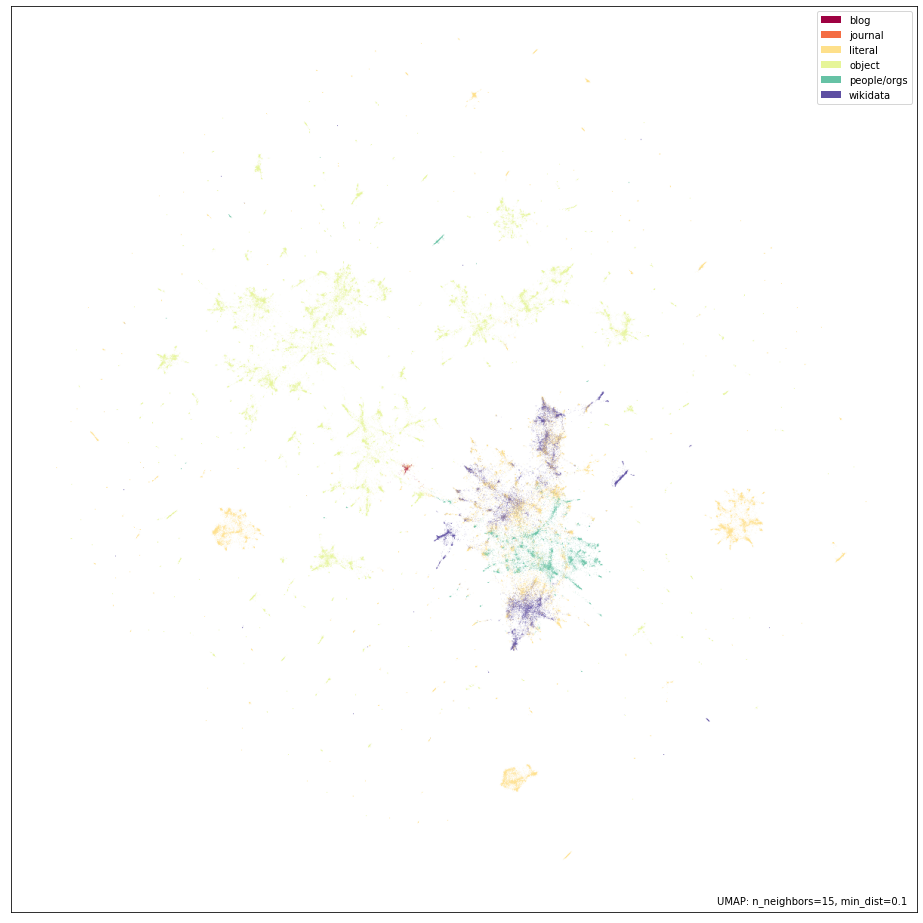

In [39]:
# interactive plotting is temperamental
# output_notebook()
# p = umap.plot.interactive(ent_reduced, labels=entlabels_small.group)
# show(p)

# ..so instead let's just create a static plot
umap.plot.points(ent_reduced, labels=entlabels_small.group, width=1200, height=1200)